 # LSTM - Le Mémorialiste Séquentiel
Métaphore : C'est un expert avec une excellente mémoire à court et à long terme. Il lit l'histoire de vos données comme une phrase, mot par mot, et se souvient du contexte.

Comment il réfléchit : Il analyse une séquence de jours (par exemple, les 60 derniers jours).

Il possède une "mémoire interne" qui lui permet de retenir des informations importantes vues au début de la séquence (par exemple, "nous sommes au début d'une période de croissance").
Il fait défiler la séquence jour après jour, en mettant à jour sa mémoire.
À la fin, il utilise tout ce qu'il a appris et retenu sur la séquence pour deviner le "mot" suivant (la valeur de l'NDVI du lendemain).
Sa grande force est de comprendre l'ordre des événements. Il sait que "beaucoup de pluie" suivi de "beaucoup de soleil" n'a pas le même effet que l'inverse.

Force principale : Théoriquement le plus puissant pour comprendre des dynamiques temporelles complexes.

Faiblesse principale : Très long et complexe à entraîner, nécessite beaucoup de données et peut être sujet à des problèmes techniques (comme l'erreur loss: nan que nous avons vue).

In [1]:
# Installation des bibliothèques nécessaires
!pip install tensorflow scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Charger et préparer les données fusionnées
df_final = pd.read_csv("data_fusionner_netoyeer.csv")
df_final['date'] = pd.to_datetime(df_final['date'])
df_final = df_final.set_index('date').sort_index()
print("✅ Données chargées.")
print(df_final.head())
print(df_final.tail())
print(df_final.info())

✅ Données chargées.
                NDVI  NDVI_smoothed  precipitation  temperature         RH
date                                                                      
2018-01-20  0.134869            NaN       0.000000    12.134522  57.697033
2018-01-22  0.078602            NaN       0.000000    14.060856  45.916110
2018-02-07  0.074299       0.097647       0.078841     5.807220  54.461943
2018-02-14  0.119501       0.109564       0.000000    13.289267  42.479021
2018-02-23  0.080963       0.111181       0.000000    14.516624  38.952163
                NDVI  NDVI_smoothed  precipitation  temperature         RH
date                                                                      
2024-11-20  0.143553       0.102539            0.0    17.146216  57.177976
2024-11-22  0.079536       0.113988            0.0    16.821888  44.651478
2024-11-29  0.104598       0.108077            0.0    20.752578  29.855633
2024-12-06  0.136830            NaN            0.0    18.309847  32.570570
2024-

In [2]:

# Charger et préparer les données fusionnées
df_final = pd.read_csv("data_fusionner_netoyeer.csv")
df_final['date'] = pd.to_datetime(df_final['date'])
df_final = df_final.set_index('date').sort_index()
print("✅ Données chargées.")
print(df_final.head())
print(df_final.tail())
print(df_final.info())

✅ Données chargées.
                NDVI  NDVI_smoothed  precipitation  temperature         RH
date                                                                      
2018-01-20  0.134869            NaN       0.000000    12.134522  57.697033
2018-01-22  0.078602            NaN       0.000000    14.060856  45.916110
2018-02-07  0.074299       0.097647       0.078841     5.807220  54.461943
2018-02-14  0.119501       0.109564       0.000000    13.289267  42.479021
2018-02-23  0.080963       0.111181       0.000000    14.516624  38.952163
                NDVI  NDVI_smoothed  precipitation  temperature         RH
date                                                                      
2024-11-20  0.143553       0.102539            0.0    17.146216  57.177976
2024-11-22  0.079536       0.113988            0.0    16.821888  44.651478
2024-11-29  0.104598       0.108077            0.0    20.752578  29.855633
2024-12-06  0.136830            NaN            0.0    18.309847  32.570570
2024-

--- Statistiques Descriptives ---
             NDVI  NDVI_smoothed  precipitation  temperature          RH
count  329.000000     325.000000     329.000000   329.000000  329.000000
mean     0.115853       0.116003       0.244832    23.675857   33.327647
std      0.038485       0.019581       0.837372     7.319718   11.613460
min      0.069456       0.088910       0.000000     5.807220   11.585891
25%      0.084347       0.101844       0.000000    17.517000   24.177973
50%      0.106093       0.109803       0.000000    24.337928   31.977711
75%      0.132948       0.125935       0.074760    29.456844   41.698876
max      0.253773       0.184251      10.596684    37.471479   71.086975


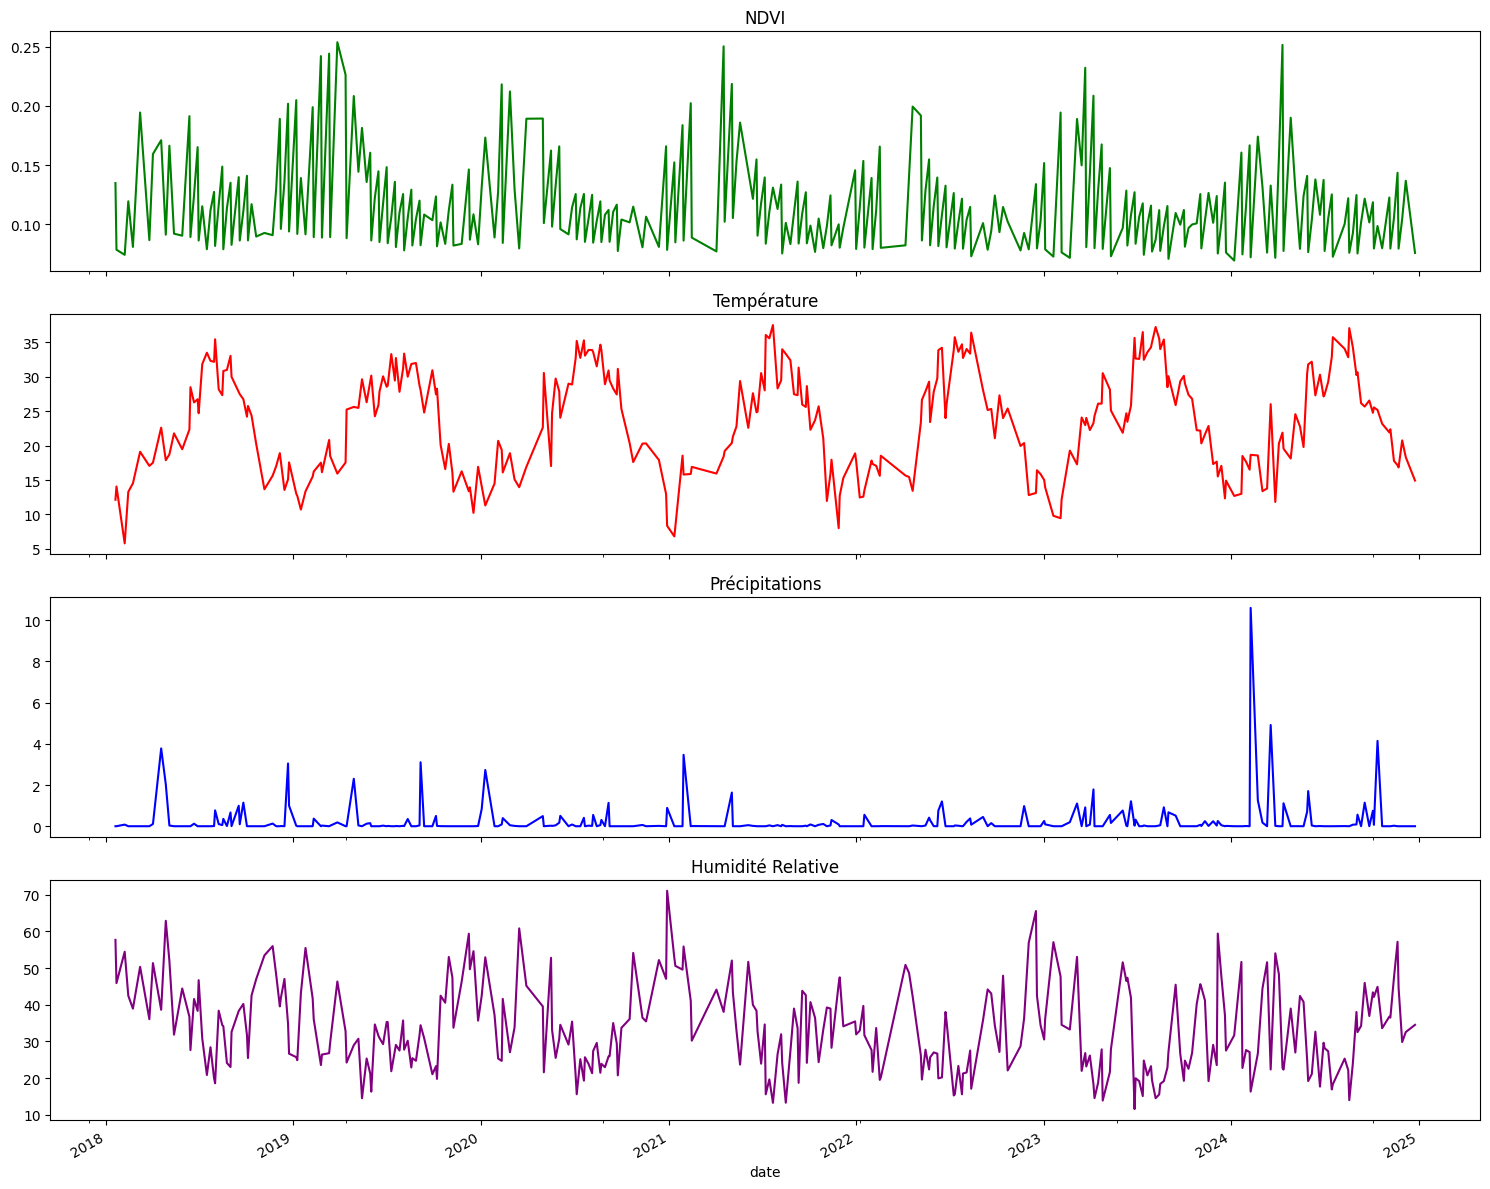

In [3]:
# Statistiques descriptives
print("--- Statistiques Descriptives ---")
print(df_final.describe())

# Visualisation des séries
fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
df_final['NDVI'].plot(ax=axes[0], title='NDVI', color='green')
df_final['temperature'].plot(ax=axes[1], title='Température', color='red')
df_final['precipitation'].plot(ax=axes[2], title='Précipitations', color='blue')
df_final['RH'].plot(ax=axes[3], title='Humidité Relative', color='purple')
plt.tight_layout()
plt.show()

In [4]:
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df_final['NDVI'])
print(f'--- Test de Stationnarité (ADF) sur l\'NDVI ---')
print(f'p-value: {adf_result[1]}')

--- Test de Stationnarité (ADF) sur l'NDVI ---
p-value: 0.00048445159334313976


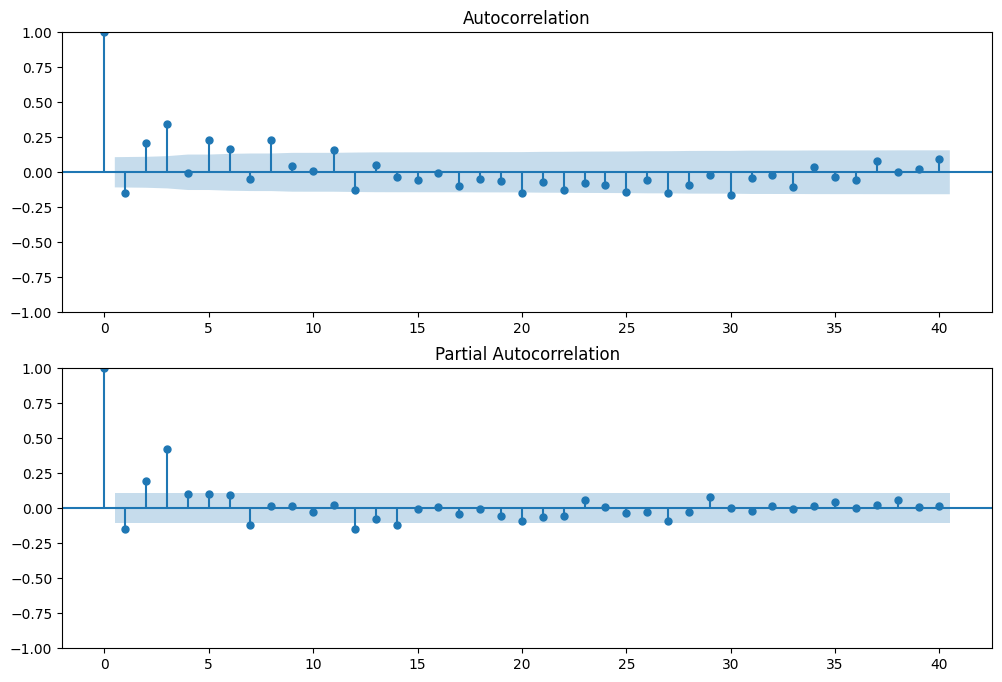

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_final['NDVI'], ax=ax1, lags=40)
plot_pacf(df_final['NDVI'], ax=ax2, lags=40)
plt.show()

In [6]:
import pandas as pd
import numpy as np

print("--- DÉBUT DU DIAGNOSTIC DES DONNÉES ---")
try:
    df = pd.read_csv("data_fusionner_netoyeer.csv")
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')

    print("\n1. Vérification des valeurs manquantes (NaN) AVANT tout nettoyage :")
    print(df.isnull().sum())
    print("-" * 30)

    # Tentative de réparation plus robuste
    # Remplacer les infinis par des NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    print("\n2. Vérification après avoir remplacé les valeurs infinies (inf) :")
    print(f"Nombre total de valeurs manquantes (NaN + inf) : {df.isnull().sum().sum()}")
    print("-" * 30)

    # Combler tous les NaNs restants
    # d'abord avec l'interpolation, puis en propageant la valeur suivante pour le début
    df.interpolate(method='linear', inplace=True)
    df.bfill(inplace=True) # bfill comble les NaNs au début du fichier

    print("\n3. Vérification des valeurs manquantes APRÈS nettoyage complet :")
    print(df.isnull().sum())
    print("-" * 30)

    print("\n4. Statistiques descriptives finales (pour détecter des valeurs aberrantes) :")
    print(df.describe())
    print("-" * 30)

    print("\n--- FIN DU DIAGNOSTIC ---")
    print("\nSi aucune valeur manquante n'est listée à l'étape 3, les données sont prêtes.")
    print("Veuillez partager l'intégralité de cet output.")


except FileNotFoundError:
    print("❌ ERREUR : Le fichier 'data_fusionner_netoyeer.csv' est introuvable.")
except Exception as e:
    print(f"❌ Une erreur inattendue est survenue : {e}")

--- DÉBUT DU DIAGNOSTIC DES DONNÉES ---

1. Vérification des valeurs manquantes (NaN) AVANT tout nettoyage :
NDVI             0
NDVI_smoothed    4
precipitation    0
temperature      0
RH               0
dtype: int64
------------------------------

2. Vérification après avoir remplacé les valeurs infinies (inf) :
Nombre total de valeurs manquantes (NaN + inf) : 4
------------------------------

3. Vérification des valeurs manquantes APRÈS nettoyage complet :
NDVI             0
NDVI_smoothed    0
precipitation    0
temperature      0
RH               0
dtype: int64
------------------------------

4. Statistiques descriptives finales (pour détecter des valeurs aberrantes) :
             NDVI  NDVI_smoothed  precipitation  temperature          RH
count  329.000000     329.000000     329.000000   329.000000  329.000000
mean     0.115853       0.115844       0.244832    23.675857   33.327647
std      0.038485       0.019523       0.837372     7.319718   11.613460
min      0.069456       0.0

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

print("--- DÉBUT DU SCRIPT LSTM FINAL (CORRIGÉ POUR KEYERROR) ---")

# --- ÉTAPE 1: CHARGEMENT ET NETTOYAGE ---
try:
    df_final = pd.read_csv("data_fusionner_netoyeer.csv")
    print("✅ Fichier de données chargé.")
except FileNotFoundError:
    print("❌ ERREUR : Le fichier 'data_fusionner_netoyeer.csv' est introuvable.")
    exit()

df_final['date'] = pd.to_datetime(df_final['date'])
df_final = df_final.set_index('date').sort_index()

df_final.replace([np.inf, -np.inf], np.nan, inplace=True)
df_final.interpolate(method='linear', inplace=True)
df_final.bfill(inplace=True)

if 'NDVI_smoothed' in df_final.columns:
    df_final = df_final.drop(columns=['NDVI_smoothed'])
print("✅ Données nettoyées.")


# --- ÉTAPE 2: MODÉLISATION LSTM ---
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_final)
scaler_ndvi = MinMaxScaler()
scaler_ndvi.fit(df_final[['NDVI']])

def create_sequences(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:(i + lookback), :])
        y.append(data[i + lookback, 0])
    return np.array(X), np.array(y)

lookback = 60
X_seq, y_seq = create_sequences(data_scaled, lookback)

split_ratio = 0.8
split_index = int(len(X_seq) * split_ratio)
X_train, X_test = X_seq[:split_index], X_seq[split_index:]
y_train, y_test = y_seq[:split_index], y_seq[split_index:]
print(f"✅ Données divisées : {len(X_train)} séquences pour l'entraînement, {len(X_test)} pour le test.")

print("\n--- Construction et entraînement du modèle LSTM ---")
model_lstm = Sequential([
    LSTM(70, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(35),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train, y_train,
               batch_size=32, epochs=60,
               validation_data=(X_test, y_test),
               verbose=0) # verbose=0 pour un entraînement plus silencieux
print("✅ Modèle entraîné.")






--- DÉBUT DU SCRIPT LSTM FINAL (CORRIGÉ POUR KEYERROR) ---
✅ Fichier de données chargé.
✅ Données nettoyées.
✅ Données divisées : 215 séquences pour l'entraînement, 54 pour le test.

--- Construction et entraînement du modèle LSTM ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Modèle entraîné.


In [ ]:

# Définir le nom du fichier pour votre modèle
nom_du_fichier_modele = 'modele_lstm_ndvi.keras'

# Sauvegarder le modèle complet (architecture + poids)
model_lstm.save(nom_du_fichier_modele)

print(f"✅ Modèle sauvegardé avec succès dans le fichier : {nom_du_fichier_modele}")

In [34]:

# --- ÉTAPE 3: PRÉDICTIONS FUTURES ---
print("\n--- Prédictions Futures ---")
last_sequence = data_scaled[-lookback:]
future_predictions = []
current_sequence = last_sequence.copy()

# --- CORRECTION POUR LE KEYERROR ---
# 1. Créer le template climatique moyen (qui aura des trous)
dayofyear_map = df_final.groupby(df_final.index.dayofyear)[['temperature', 'precipitation', 'RH']].mean()
# 2. Créer un index complet pour tous les jours d'une année bissextile
full_day_index = pd.Index(range(1, 367))
# 3. Re-indexer le template pour le rendre complet, en comblant les trous
dayofyear_map_complete = dayofyear_map.reindex(full_day_index, method='ffill').bfill()
# --- FIN DE LA CORRECTION ---


for i in range(365):
    next_pred_scaled = model_lstm.predict(current_sequence[np.newaxis, :, :], verbose=0)
    future_predictions.append(next_pred_scaled[0, 0])

    next_day_vector = np.zeros(current_sequence.shape[1])
    next_day_vector[0] = next_pred_scaled[0, 0]

    current_date = df_final.index[-1] + pd.Timedelta(days=i + 1)
    day_of_year = current_date.dayofyear

    # On utilise notre template complet et sans trou
    clim_values = dayofyear_map_complete.loc[day_of_year].values

    mock_record = np.hstack([np.zeros((1,1)), clim_values.reshape(1,-1)])
    scaled_clim_values = scaler.transform(mock_record)[0, 1:]
    next_day_vector[1:] = scaled_clim_values

    current_sequence = np.vstack([current_sequence[1:], next_day_vector])

future_predictions_real = scaler_ndvi.inverse_transform(np.array(future_predictions).reshape(-1, 1))
print("✅ Prédictions générées.")




--- Prédictions Futures ---


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/valida

✅ Prédictions générées.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


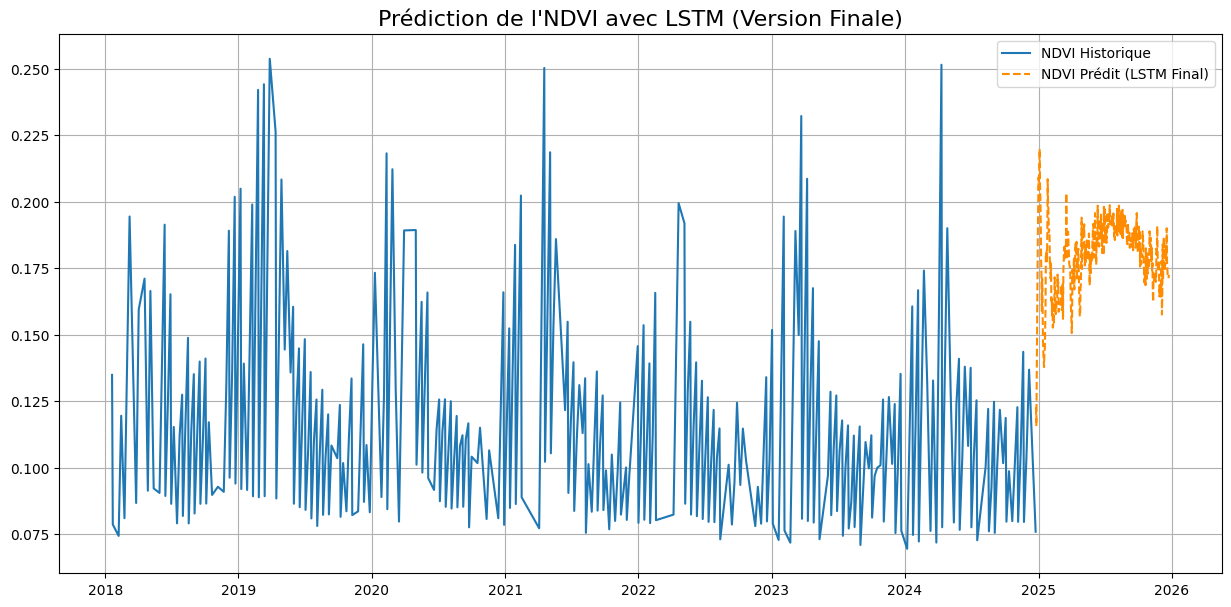

In [35]:

# --- ÉTAPE 4: VISUALISATION FINALE ---
future_dates = pd.date_range(start=df_final.index[-1] + pd.Timedelta(days=1), periods=365)
plt.figure(figsize=(15, 7))
plt.plot(df_final.index, df_final['NDVI'], label='NDVI Historique')
plt.plot(future_dates, future_predictions_real, label='NDVI Prédit (LSTM Final)', color='darkorange', linestyle='--')
plt.title("Prédiction de l'NDVI avec LSTM (Version Finale)", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step 

--- Validation sur le jeu de test ---
MAE: 0.0254
RMSE: 0.0316


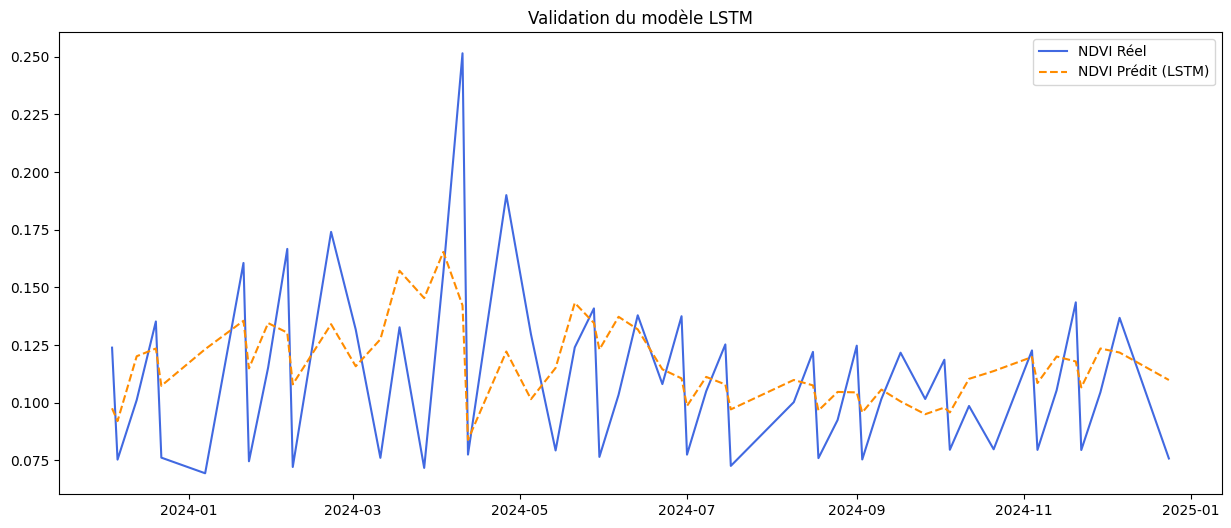

In [28]:
# Prédictions sur le jeu de test
predictions_scaled = model_lstm.predict(X_test)

# Dénormalisation des prédictions et des vraies valeurs
predictions = scaler_ndvi.inverse_transform(predictions_scaled)
y_test_real = scaler_ndvi.inverse_transform(y_test.reshape(-1, 1))

# Métriques d'erreur
mae = mean_absolute_error(y_test_real, predictions)
rmse = np.sqrt(mean_squared_error(y_test_real, predictions))
print(f'\n--- Validation sur le jeu de test ---')
print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')

# Visualisation des prédictions vs valeurs réelles
plt.figure(figsize=(15, 6))
plt.plot(df_final.index[-len(y_test_real):], y_test_real, label='NDVI Réel', color='royalblue')
plt.plot(df_final.index[-len(predictions):], predictions, label='NDVI Prédit (LSTM)', color='darkorange', linestyle='--')
plt.title('Validation du modèle LSTM')
plt.legend()
plt.show()


--- Prédictions Futures ---
🔮 Génération des prédictions pour l'année suivante...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/valida

✅ Prédictions générées.


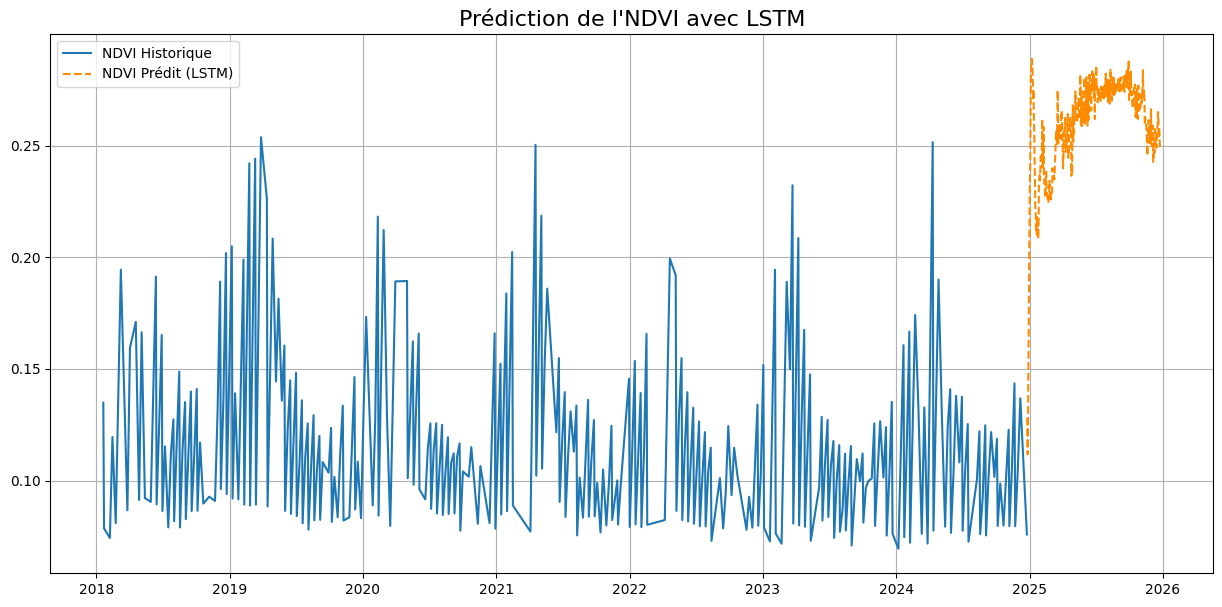

In [29]:
# --- ÉTAPE 3 CORRIGÉE : PRÉDICTIONS FUTURES ---

print("\n--- Prédictions Futures ---")

# On récupère la dernière séquence de données réelles comme point de départ
last_sequence = data_scaled[-lookback:]
future_predictions = []
current_sequence = last_sequence.copy()

# --- LA CORRECTION EST ICI ---
# 1. Créer le template climatique moyen (qui aura des trous)
dayofyear_map = df_final.groupby(df_final.index.dayofyear)[['temperature', 'precipitation', 'RH']].mean()

# 2. Créer un index complet pour tous les jours d'une année (1 à 366 pour être sûr)
full_day_index = pd.Index(range(1, 367))

# 3. Re-indexer le template pour le rendre complet, en comblant les jours manquants
dayofyear_map_complete = dayofyear_map.reindex(full_day_index, method='ffill').bfill()
# --- FIN DE LA CORRECTION ---


# Boucle de prédiction jour par jour
print("🔮 Génération des prédictions pour l'année suivante...")
for i in range(365):
    # Prédire le jour suivant
    next_pred_scaled = model_lstm.predict(current_sequence[np.newaxis, :, :], verbose=0)
    future_predictions.append(next_pred_scaled[0, 0])

    # Créer le vecteur du jour futur avec des données climatiques réalistes
    next_day_vector = np.zeros(current_sequence.shape[1])
    next_day_vector[0] = next_pred_scaled[0, 0] # Le NDVI prédit

    # On récupère le climat moyen pour ce jour futur à partir du template complet
    current_date = df_final.index[-1] + pd.Timedelta(days=i + 1)
    day_of_year = current_date.dayofyear
    clim_values = dayofyear_map_complete.loc[day_of_year].values

    # On met à l'échelle ces valeurs climatiques
    mock_record = np.hstack([np.zeros((1,1)), clim_values.reshape(1,-1)])
    scaled_clim_values = scaler.transform(mock_record)[0, 1:]
    next_day_vector[1:] = scaled_clim_values

    # On met à jour la séquence pour la prochaine prédiction
    current_sequence = np.vstack([current_sequence[1:], next_day_vector])

# Dénormaliser la prédiction finale pour la rendre lisible
future_predictions_real = scaler_ndvi.inverse_transform(np.array(future_predictions).reshape(-1, 1))
print("✅ Prédictions générées.")


# --- VISUALISATION FINALE ---
future_dates = pd.date_range(start=df_final.index[-1] + pd.Timedelta(days=1), periods=365)
plt.figure(figsize=(15, 7))
plt.plot(df_final.index, df_final['NDVI'], label='NDVI Historique')
plt.plot(future_dates, future_predictions_real, label='NDVI Prédit (LSTM)', color='darkorange', linestyle='--')
plt.title("Prédiction de l'NDVI avec LSTM", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

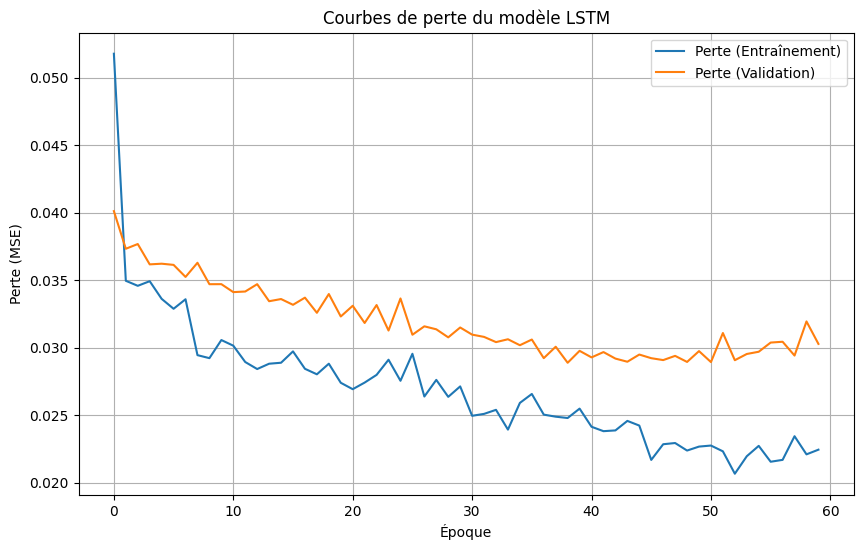

In [30]:
# Visualisation de l'historique de l'entraînement
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Perte (Entraînement)')
plt.plot(history.history['val_loss'], label='Perte (Validation)')
plt.title('Courbes de perte du modèle LSTM')
plt.xlabel('Époque')
plt.ylabel('Perte (MSE)')
plt.legend()
plt.grid(True)
plt.show()